In [ ]:
import config
import imageNormalizer
from movie import Movie

import holoviews as hv
hv.extension('bokeh')
import bokeh
from bokeh.io import output_notebook, show
import bokeh.plotting as bp # figure, show, output_file
output_notebook()
import matplotlib.pyplot as plt

from talk_plottingutils import plot_image_mpl, plot_image_rgb_bokeh, plot_image_bokeh, \
                               hv_plot_stack, plot_segmentation_bokeh, plot_segmentation, normalize01
from talk_utils import tile_raster_images


# skimage
from skimage.morphology import closing, opening, disk, dilation, watershed, local_maxima
from skimage.measure import label, regionprops
from skimage.segmentation import find_boundaries, mark_boundaries
from scipy.ndimage.morphology import binary_fill_holes, distance_transform_edt

import numpy as np
import toolz

# Segmentation

![Segmentation](images/segmentation/segmentation.png)

**Steps**:
1. separate BG and FG: **MSER**
![MSER](images/segmentation/mser.png)

2. split clumped objects: **Watershed** ![Segmentation](images/segmentation/watershed.png)


## Setup
        conda install opencv

In [3]:
import cv2

config.TTTDIR = '/home/michi/pythonProjects/deepLearning/Hemato_korea/data/'
movie = Movie('experiment3', verbose=False)  # 140206

loading a single image from disk and transforming to unit8

In [ ]:
timepoint = 3055
position = 54
I = movie.loadimage(position, timepoint, WL='w00', extension='png', normalizer=imageNormalizer.BaSiC_Normalizer())

def raw_transform(I):
    "scales it into [0,255] and transofrms into uint8"
    I = I - I.min()
    I = I/I.max()
    I = (I*2**8).astype('uint8')
    return I

I = raw_transform(I)

plot_image_bokeh(I);

# MSER

In [4]:
mser = cv2.MSER_create()

# MSER has a few parameters to be set
mser_delta = 4
mser_min = 20    # min size of object
mser_max = 4000  # max size of object
mser.setDelta(mser_delta)
mser.setMinArea(mser_min)
mser.setMaxArea(mser_max)

detect **MSER-regions** and put them into a binary FG/BG **mask**


In [ ]:
def regions2mask(regions, ishape):
    "turns a list of pixel coordinates into a binary image mask"
    bw = np.zeros(ishape)
    for r in regions:
        for i in range(len(r)): 
            bw[r[i,1], r[i,0]] = 1  # the usual row/col/x/y switch
    return bw

regions = mser.detectRegions(I, None)
seg_mask = regions2mask(regions, I.shape)
plot_segmentation_bokeh(I, seg_mask)

some postprocessing of the segmentation mask:
- Closing
- Hole fill
- Opening


In [ ]:
def mser_postprocess(seg_mask):
    "morphological operations to enhacne the segmentation"
    bw_closed = closing(seg_mask, disk(2))
    # TODO brige operation missing
    filled_bw = binary_fill_holes(bw_closed)
    opened_bw = opening(filled_bw, disk(2))
    return opened_bw

opened_bw = mser_postprocess(seg_mask)
# plot_segmentation(I, opened_bw)
plot_segmentation_bokeh(I, opened_bw)

## Watershedding
to split merged objects.

1. find initial centers of cells
2. watershedding starting from the centers
<img src="images/segmentation/watershed_scetch.png" alt="Watershedding" style="width: 600px;" title="http://www.mdpi.com/2072-4292/6/1/776/htm"/>

### finding seeds for the watershed
i.e. locate the centers of the forground objects
- **distance transform**: distance of each pixel to the next background pixel
- more sophisticated: Circular **Hough transform** (not implemented here)

In [ ]:
dist_transform = cv2.distanceTransform(opened_bw.astype('uint8'),cv2.DIST_L2,5)
plot_segmentation_bokeh(I, normalize01(dist_transform))

# plt.figure(figsize=(30,30))
# plot_segmentation(I, dist_transform); plt.show()

**Look for local maxima in he distance transform** to get pixels in the center of objects

In [ ]:
sure_fg = local_maxima(dist_transform)
sure_fg = dilation(sure_fg, disk(1))  # enlarge these single pixel centers, merging nearby maxima
plot_segmentation_bokeh(I, sure_fg)

### actual watershed
finds the border between adjacent cell centers

In [11]:
def permute_labels(marked_img):
    """
    given a labeled segmentation mask (each object has its unique integer in the mask)
    randomize the labeling. ACtually just useful for visualization, giving different color to neighbouring objects
    """
    M = np.unique(marked_img)
    # kick out zeros as this marks background
    M = M[M!=0]
    N = np.random.choice(M, size=len(M),replace=False) 
    new_marks = np.zeros(marked_img.shape)
    
    for i, m in enumerate(M):
        new_label = N[i]
        new_marks+= np.full(marked_img.shape, new_label) * (marked_img==m)
    return new_marks  

In [ ]:
markers = label(sure_fg)
markers = permute_labels(markers)  # just for visualization to mix colors

# plt.figure(figsize=(20,20)); plt.imshow(markers, cmap=plt.cm.nipy_spectral); plt.grid();plt.show()
plot_image_bokeh(markers, cmap='RdGy11');

In [13]:
labels_ws = watershed(-dist_transform, markers, mask=opened_bw)

In [ ]:
plot_image_bokeh(labels_ws, cmap='RdGy11')
# plt.figure(figsize=(20,20)); plt.imshow(labels_ws, cmap=plt.cm.nipy_spectral); plt.grid();plt.show()

**filter** out obvious non-cell objects:
- non-round 
- too large/small


In [15]:
area, ecc = zip(*[(r.area, r.eccentricity) 
                  for r in regionprops(labels_ws, intensity_image=None, cache=True)])

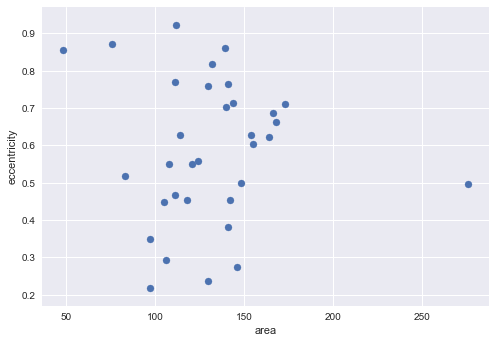

In [16]:
plt.scatter(area, ecc)
plt.xlabel('area')
plt.ylabel('eccentricity')
plt.show()

In [17]:
def filter_segObjects(labels_ws):

    #labels_ws: segmentation mask, each object with a different integer
    
    eccfilter = 0.99;
    ecccombfilter = 0.7;
    maxsizecombfilter = 700;
    minsize = 40;
    maxsize = 1000;
    
    filtered = np.zeros(labels_ws.shape, dtype=np.bool)
    for r in regionprops(labels_ws, intensity_image=None, cache=True):
        if not minsize < r.area < maxsize \
            or r.eccentricity >  eccfilter\
            or (r.eccentricity>ecccombfilter and r.area>maxsizecombfilter):

            filtered[labels_ws==r.label]= 1
    # masks out the filtered objects in the segmentation mask
    labels_ws = labels_ws * (1-filtered)
    return labels_ws

labels_ws_filtered = filter_segObjects(labels_ws)

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(labels_ws_filtered, cmap=plt.cm.nipy_spectral)
plt.grid()
plt.show()

### separate the objects in the segmentation mask
even though we know the individual cells no, let's split them in the segmentation mask, i.e. delete the boundary pixels

In [19]:
def separate_objects(labels_ws):
    "separates segmented objects that touch each other, ie setting their border to background"
    outer_bound = find_boundaries(labels_ws, mode='outer')
    touching_object_pixels = outer_bound * opened_bw

    # set these touching pixels to background in the segmantation mask (so that the obejcts are distinct)
    final_segmentation = labels_ws > 0
    final_segmentation[touching_object_pixels==True] = 0
    return final_segmentation

final_segmentation = separate_objects(labels_ws_filtered)

In [ ]:
# plot_segmentation(I, final_segmentation); plt.show()
plot_segmentation_bokeh(I, final_segmentation)

### Patch extraction
extract 27x27 image patches around the segmentation centers

In [ ]:
def extract_patches(bw_segmentation):
    centers = [np.ceil(_.centroid) .astype('int')
                        for _ in regionprops(label(bw_segmentation), intensity_image=None, cache=True)]
    patches = []
    for y, x in centers:
        patches.append(I0[y-13:y+13, x-13:x+13])
    return np.stack(patches)

patches = extract_patches(final_segmentation)
tile_raster_images(patches, img_dim=(1,2), tile_shape=(7,7))
plt.grid(); plt.show()

## Pipelining the segmentation

In [23]:
VERBOSE= False
def applyMSER(I):
    mser = cv2.MSER_create()

    # MSER has a few parameters to be set
    mser_delta = 4
    mser_min = 20
    mser_max = 4000
    mser.setDelta(mser_delta)
    mser.setMinArea(mser_min)
    mser.setMaxArea(mser_max)
    regions = mser.detectRegions(I, None)
    seg_mask = regions2mask(regions, I.shape)
    opened_bw = mser_postprocess(seg_mask)
    
    if VERBOSE:
        plot_segmentation_bokeh(raw_transform(I), opened_bw)
    return opened_bw

def applyWatershed(bw_segmentation_mask):
    # bw_segmentation_mask: a binary segmentation mask
    dist_transform = cv2.distanceTransform(bw_segmentation_mask.astype('uint8'),cv2.DIST_L2,5)

    sure_fg = local_maxima(dist_transform)
    sure_fg = dilation(sure_fg, disk(1))
    if VERBOSE:
        plot_segmentation_bokeh(sure_fg, sure_fg)
   
    markers = label(sure_fg)
    labels_ws = watershed(-dist_transform, markers, mask=bw_segmentation_mask)
    
    if VERBOSE:
        plot_segmentation_bokeh(I, labels_ws)

    return labels_ws

segmentation_function = toolz.compose(separate_objects, filter_segObjects, applyWatershed, applyMSER,raw_transform)

In [ ]:
I0 = movie.loadimage(position, timepoint, WL='w00', extension='png', normalizer=imageNormalizer.BaSiC_Normalizer())
final_segmentation = segmentation_function(I0)
plot_segmentation_bokeh(raw_transform(I0), final_segmentation)

# Loading preexisting segmentation
Let's use a more sophisticated existing segmentation [`Buggenthin et al.`] for some further analysis.
Here, the entire movie is segmented, and we can get the segmentation/image patches as well as some features of these cells.

{'x': 740.3384615384615, 'y': 134.7076923076923, 'position': 54, 'timepoint': 2855, 'area': 130, 'w01': None, 'w02': None, 'w03': None, 'w01_SLIC': None, 'w02_SLIC': None, 'w03_SLIC': None, 'h5counter': 0, 'uniqueKey': 'p54_t2855_0'}


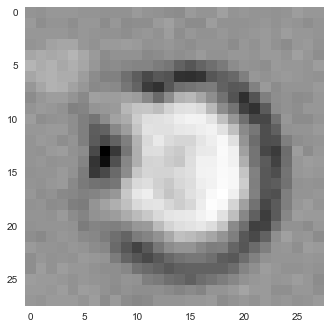

In [29]:
# get all segmented objects from a time/position
properties, images, cropped_flag = movie.get_segmented_objects_from_images(timepoint=2855, position=54)

print(properties[0]) # properies of the first segmented object
plt.imshow(images[0]); plt.grid(); plt.show() # image of that cell

lets compare to our segmentation

In [31]:
seg_objs_centroids = [(info['x'], info['y']) 
                      for info in movie.get_segmented_objects_from_images(timepoint, position)[0]]
seg_objs_centroids = np.array(seg_objs_centroids)

In [ ]:
plot_image_bokeh(I, points=seg_objs_centroids);

In [ ]:
plot_segmentation_bokeh(I, segmentation_function(I))

## Cell numbers over time
Looking at the number of segmented objects over time in the two positions


In [ ]:
tmin, tmax = 2700,3000

plt.figure()
for pos in [54,55]:
    prop_generator = (movie.get_segmented_objects_from_images(timepoint=_, position=pos)[0] 
                      for _ in range(tmin,tmax))
    Q = toolz.concat(prop_generator)
    timepoints = toolz.pluck('timepoint', Q)
    timepoint_histogram = toolz.frequencies(timepoints)
    t, freq = list(zip(*timepoint_histogram.items()))
    plt.plot(t,freq)
    plt.xlabel('Time')
    plt.ylabel('#cells')
plt.show()

## Cell locations over time

In [36]:
prop_generator = (movie.get_segmented_objects_from_images(timepoint=_, position=54)[0] for _ in range(2700,2800))
Q = toolz.concat(prop_generator)
xyta = toolz.pluck(['x','y','timepoint', 'area'], Q)
x,y,t, a = zip(*xyta)

In [ ]:
plt.scatter(x,y,c=t, s=np.array(a)*0.1, cmap=plt.cm.viridis)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

In [ ]:
img_generator = (np.stack(movie.get_segmented_objects_from_images(timepoint=_, position=55)[1]) for _ in range(3000,3100))
cell_imgs = np.concatenate(list(img_generator), axis=0)
cell_imgs.shape

In [ ]:
tile_raster_images(cell_imgs, img_dim=(1,2), tile_shape=(60,60), figsize=(30,30))
plt.grid();plt.show()